In [40]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, gamma, nbinom, trim_mean
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from google.cloud import bigquery, storage
# import bigframes.pandas as bpd
import sys
import warnings
warnings.filterwarnings('ignore')
from math import inf
from itertools import islice


# For BigQuery queries
project_id = 'sc-bq-ds-adhoc'
client = bigquery.Client(project=project_id)

In [41]:
table_names = {
    'one_day_pop': 'all_traffic_without_filters_20251201',
    'one_day_sample': 'all_traffic_without_filters_seeds_20251201',
    'one_week_pop': 'global_20260101_20260107',
    'one_week_sample': 'ab_data_20260101_20260107'
}

In [42]:
def calculate_sla_metrics(table_name, gbb_filter=None, is_sample=False):
    """
    Calculates SLA metrics for either the whole population or simulation samples.

    Parameters:
    - gbb_filter: Specific optimization goal to filter by.
    - is_sample: If True, uses the seeded/simulated table and groups by sim_id.
    """

    # 1. Determine table and grouping based on mode
    # table_name = "all_traffic_without_filters_seeds_20251201" if is_sample else "all_traffic_without_filters_20251201"
    sim_col = "sim_id," if is_sample else ""
    sim_group = "sim_id," if is_sample else ""

    condition = f"and optimization_goal = '{gbb_filter}'" if gbb_filter else ""

    query = f"""
    with agg_li as (
        select
            {sim_col}
            line_item_id,
            sum(conversions) as conversions,
            sum(predicted_conversions) as conversions_pred,
            sum(revenue) as revenue
        from `sc-analytics-privacy.ad_hoc_analysis.{table_name}`
        where 1=1
        {condition}
        group by all
    )
    select
        *,
        case
            when conversions > 0
                 and (conversions_pred / conversions) > 0.8
                 and (conversions_pred / conversions) < 1.2
            then 1 else 0
        end as sla_flag
    from agg_li
    """

    df_li = client.query(query).to_dataframe()

    # Pre-calculate Revenue weighted SLA value row-wise
    df_li['rev_sla'] = df_li['sla_flag'] * df_li['revenue']

    return df_li

In [43]:
df_all_1201 = calculate_sla_metrics(table_name = table_names['one_day_pop'])
df_sampled_1201 = calculate_sla_metrics(table_name = table_names['one_day_sample'], is_sample=True)

E0000 00:00:1770944732.856473 2851288 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1770944737.206917 2851288 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [44]:
def estimate_line_item_priors(df_population, prob_col='sla_flag', weight_col='conversions'):
    """
    Estimate a prior for EACH line item based purely on its own data.
    NO global. Just its own rate and sqrt(conversions) as strength.
    """
    line_item_priors = {}
    
    for _, row in df_population.iterrows():
        li_id = row['line_item_id']
        sla = row[prob_col]
        conv = row[weight_col]
        
        p_li = np.clip(sla, 1e-6, 1-1e-6)
        nu_li = np.sqrt(max(conv, 1e-6))
        
        line_item_priors[li_id] = (p_li * nu_li, (1 - p_li) * nu_li)
    
    print(f"Estimated priors for {len(line_item_priors)} line items (pure own data)")
    return line_item_priors


line_item_priors = estimate_line_item_priors(df_all_1201)

Estimated priors for 132144 line items (pure own data)


=== Overdispersion Analysis ===

1. COUNT DATA (conversions):
   Mean: 290.88
   Variance: 17461500.03
   Dispersion ratio (Var/Mean): 60030.78
   → OVERDISPERSED (ratio > 1 = overdispersed)

2. BINARY DATA (sla_flag):
   Observed p: 0.2217
   Theoretical Var [p(1-p)]: 0.1726
   Observed Var: 0.1726
   Dispersion ratio: 1.0000
   → Binary data is always underdispersed (ratio ≤ 1)

3. CALIBRATION RATIO (pred/actual) - for 68567 line items with conv > 0:
   Mean: 1.3092
   Variance: 15.2295
   Std Dev: 3.9025
   CV (Std/Mean): 2.9808

4. NEGATIVE BINOMIAL fit:
   Dispersion parameter r: 0.0048
   (smaller r = more overdispersion)


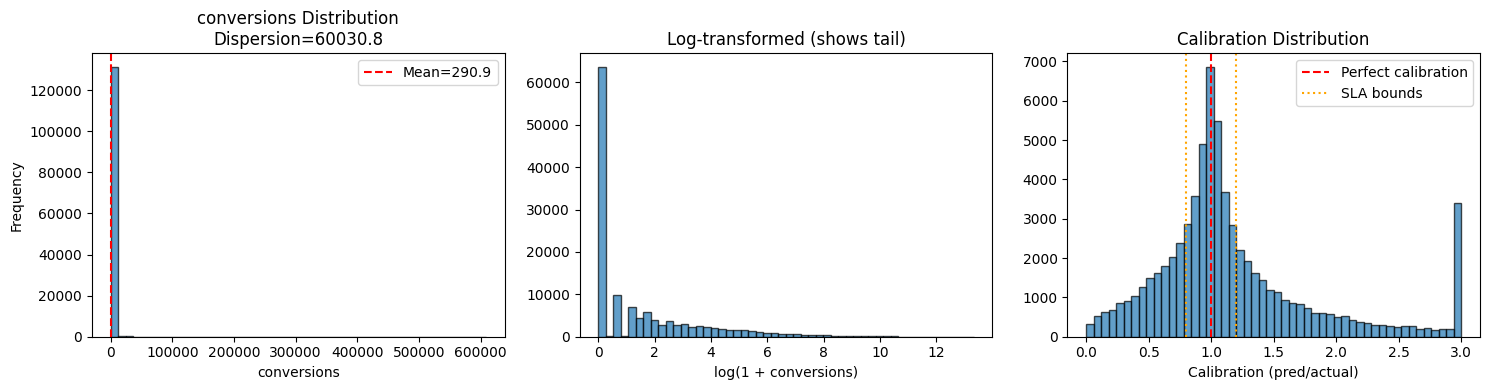

In [45]:
# Calculate Overdispersion in df_all_1201

def calculate_overdispersion(df, count_col='conversions', binary_col='sla_flag'):
    """
    Calculate overdispersion metrics for count and binary data.
    
    Overdispersion = observed variance > theoretical variance
    """
    print("=== Overdispersion Analysis ===\n")
    
    # 1. COUNT DATA (Poisson assumption: Var = Mean)
    counts = df[count_col].values
    mean_count = counts.mean()
    var_count = counts.var()
    dispersion_ratio = var_count / mean_count
    
    print(f"1. COUNT DATA ({count_col}):")
    print(f"   Mean: {mean_count:.2f}")
    print(f"   Variance: {var_count:.2f}")
    print(f"   Dispersion ratio (Var/Mean): {dispersion_ratio:.2f}")
    print(f"   → {'OVERDISPERSED' if dispersion_ratio > 1 else 'OK'} (ratio > 1 = overdispersed)")
    
    # 2. BINARY DATA (Bernoulli assumption: Var = p(1-p))
    p_hat = df[binary_col].mean()
    theoretical_var = p_hat * (1 - p_hat)
    observed_var = df[binary_col].var()
    binary_dispersion = observed_var / theoretical_var
    
    print(f"\n2. BINARY DATA ({binary_col}):")
    print(f"   Observed p: {p_hat:.4f}")
    print(f"   Theoretical Var [p(1-p)]: {theoretical_var:.4f}")
    print(f"   Observed Var: {observed_var:.4f}")
    print(f"   Dispersion ratio: {binary_dispersion:.4f}")
    print(f"   → Binary data is always underdispersed (ratio ≤ 1)")
    
    # 3. CALIBRATION RATIO (pred/actual)
    # Filter to avoid division by zero
    df_valid = df[df[count_col] > 0].copy()
    df_valid['calibration'] = df_valid['conversions_pred'] / df_valid[count_col]
    
    calib_mean = df_valid['calibration'].mean()
    calib_var = df_valid['calibration'].var()
    calib_std = df_valid['calibration'].std()
    
    print(f"\n3. CALIBRATION RATIO (pred/actual) - for {len(df_valid)} line items with conv > 0:")
    print(f"   Mean: {calib_mean:.4f}")
    print(f"   Variance: {calib_var:.4f}")
    print(f"   Std Dev: {calib_std:.4f}")
    print(f"   CV (Std/Mean): {calib_std/calib_mean:.4f}")
    
    # 4. NEGATIVE BINOMIAL dispersion parameter (r)
    # For Neg Binomial: Var = Mean + Mean²/r
    # Solving: r = Mean² / (Var - Mean)
    if var_count > mean_count:
        r_negbin = (mean_count ** 2) / (var_count - mean_count)
        print(f"\n4. NEGATIVE BINOMIAL fit:")
        print(f"   Dispersion parameter r: {r_negbin:.4f}")
        print(f"   (smaller r = more overdispersion)")
    
    # 5. Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Count distribution
    ax1 = axes[0]
    ax1.hist(counts, bins=50, edgecolor='black', alpha=0.7)
    ax1.axvline(mean_count, color='red', linestyle='--', label=f'Mean={mean_count:.1f}')
    ax1.set_xlabel(count_col)
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'{count_col} Distribution\nDispersion={dispersion_ratio:.1f}')
    ax1.legend()
    
    # Log-scale for heavy tail
    ax2 = axes[1]
    ax2.hist(np.log1p(counts), bins=50, edgecolor='black', alpha=0.7)
    ax2.set_xlabel(f'log(1 + {count_col})')
    ax2.set_title('Log-transformed (shows tail)')
    
    # Calibration distribution
    ax3 = axes[2]
    ax3.hist(df_valid['calibration'].clip(0, 3), bins=50, edgecolor='black', alpha=0.7)
    ax3.axvline(1.0, color='red', linestyle='--', label='Perfect calibration')
    ax3.axvline(0.8, color='orange', linestyle=':', label='SLA bounds')
    ax3.axvline(1.2, color='orange', linestyle=':')
    ax3.set_xlabel('Calibration (pred/actual)')
    ax3.set_title('Calibration Distribution')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'count_dispersion': dispersion_ratio,
        'binary_dispersion': binary_dispersion,
        'calib_mean': calib_mean,
        'calib_var': calib_var
    }

# Run overdispersion analysis
overdispersion_stats = calculate_overdispersion(df_all_1201)

PRIOR STRENGTH DIAGNOSIS

1. KEY VALUES:
   p_bar (weighted mean SLA rate): 0.6992
   max_v = p(1-p):                 0.2103
   v_bar (observed variance):      0.2103
   variance_ratio (v_bar/max_v):   1.0000
   nu_est = max_v/v_bar - 1:       0.0000

2. INTERPRETATION:
   The variance ratio of 100.00% means:
   → Observed variance is 100.0% of the MAXIMUM possible
   → This is HIGH variance

   ⚠️  VERY HIGH variance (100.0%)
   → Data behaves almost like independent coin flips
   → Little information to 'borrow' across line items
   → Prior strength ≈ 0.0 means prior has ~0.0 'pseudo-observations'

3. WHY IS THIS HAPPENING?

   SLA rate by conversion volume:
             mean_sla  std_sla  n_items
conv_bucket                            
0-1            0.1536   0.3606    10143
1-10           0.2554   0.4361    25034
10-50          0.4877   0.4999    15096
50-100         0.6729   0.4692     4766
100+           0.7966   0.4026    13528

   Correlation(SLA, conversions): 0.0884

4. WHAT 

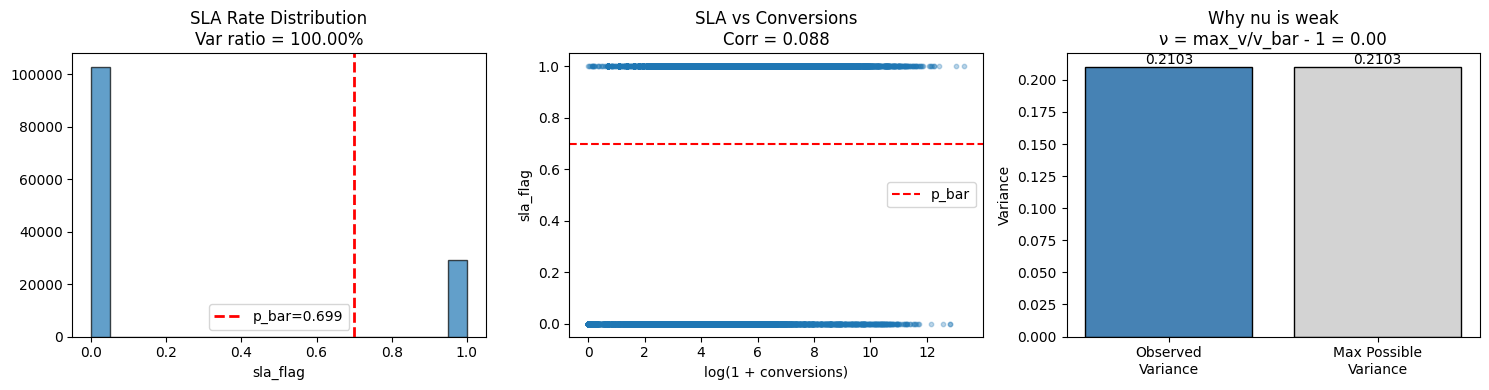

In [46]:
# Diagnose WHY the Beta prior strength (nu) is weak

def diagnose_prior_strength(df, prob_col='sla_flag', weight_col='conversions'):
    """
    Explain why nu = (max_v / v_bar) - 1 yields weak strength.
    
    The formula comes from Beta method of moments:
    - For Beta(α, β), variance = p(1-p)/(α+β+1) = p(1-p)/(ν+1)
    - Rearranging: ν = p(1-p)/variance - 1
    
    Weak strength (low ν) happens when variance is HIGH relative to p(1-p).
    """
    
    # 1. Calculate the components
    x = df[prob_col].values
    w = np.sqrt(df[weight_col].values + 1e-6)
    
    p_bar = np.average(x, weights=w)
    p_bar = np.clip(p_bar, 1e-6, 1-1e-6)
    
    v_bar = np.average((x - p_bar)**2, weights=w)
    max_v = p_bar * (1 - p_bar)
    
    variance_ratio = v_bar / max_v
    nu_est = (max_v / v_bar) - 1.0
    
    print("=" * 60)
    print("PRIOR STRENGTH DIAGNOSIS")
    print("=" * 60)
    
    print(f"\n1. KEY VALUES:")
    print(f"   p_bar (weighted mean SLA rate): {p_bar:.4f}")
    print(f"   max_v = p(1-p):                 {max_v:.4f}")
    print(f"   v_bar (observed variance):      {v_bar:.4f}")
    print(f"   variance_ratio (v_bar/max_v):   {variance_ratio:.4f}")
    print(f"   nu_est = max_v/v_bar - 1:       {nu_est:.4f}")
    
    print(f"\n2. INTERPRETATION:")
    print(f"   The variance ratio of {variance_ratio:.2%} means:")
    print(f"   → Observed variance is {variance_ratio:.1%} of the MAXIMUM possible")
    print(f"   → This is {'HIGH' if variance_ratio > 0.5 else 'MODERATE' if variance_ratio > 0.2 else 'LOW'} variance")
    
    if variance_ratio > 0.9:
        print(f"\n   ⚠️  VERY HIGH variance ({variance_ratio:.1%})")
        print(f"   → Data behaves almost like independent coin flips")
        print(f"   → Little information to 'borrow' across line items")
        print(f"   → Prior strength ≈ {nu_est:.1f} means prior has ~{nu_est:.1f} 'pseudo-observations'")
    elif variance_ratio > 0.5:
        print(f"\n   ⚠️  HIGH variance ({variance_ratio:.1%})")
        print(f"   → Line items are heterogeneous in their SLA rates")
        print(f"   → Prior can only provide weak regularization")
    else:
        print(f"\n   ✓ MODERATE variance ({variance_ratio:.1%})")
        print(f"   → Good amount of similarity across line items")
        print(f"   → Prior strength is reasonable")
    
    print(f"\n3. WHY IS THIS HAPPENING?")
    
    # Check heterogeneity by conversion volume
    df_copy = df.copy()
    df_copy['conv_bucket'] = pd.cut(df_copy[weight_col], 
                                     bins=[0, 1, 10, 50, 100, np.inf],
                                     labels=['0-1', '1-10', '10-50', '50-100', '100+'])
    
    bucket_stats = df_copy.groupby('conv_bucket', observed=True).agg({
        prob_col: ['mean', 'std', 'count']
    }).round(4)
    bucket_stats.columns = ['mean_sla', 'std_sla', 'n_items']
    
    print(f"\n   SLA rate by conversion volume:")
    print(bucket_stats.to_string())
    
    # Check if SLA rate varies systematically with conversions
    corr = df[[prob_col, weight_col]].corr().iloc[0, 1]
    print(f"\n   Correlation(SLA, conversions): {corr:.4f}")
    if abs(corr) > 0.1:
        print(f"   → SLA rate {'increases' if corr > 0 else 'decreases'} with conversion volume")
        print(f"   → This heterogeneity inflates variance")
    
    print(f"\n4. WHAT THIS MEANS FOR SHRINKAGE:")
    print(f"   With nu = {nu_est:.1f}, posterior is:")
    print(f"   → post_p = (k + {nu_est:.1f}*p_bar) / (n + {nu_est:.1f})")
    print(f"   → A line item with n=10 observations gets:")
    print(f"      - Weight on data: {10/(10+nu_est):.1%}")
    print(f"      - Weight on prior: {nu_est/(10+nu_est):.1%}")
    print(f"   → A line item with n=100 observations gets:")
    print(f"      - Weight on data: {100/(100+nu_est):.1%}")
    print(f"      - Weight on prior: {nu_est/(100+nu_est):.1%}")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Distribution of SLA rates
    ax1 = axes[0]
    ax1.hist(x, bins=20, edgecolor='black', alpha=0.7)
    ax1.axvline(p_bar, color='red', linestyle='--', linewidth=2, label=f'p_bar={p_bar:.3f}')
    ax1.set_xlabel(prob_col)
    ax1.set_title(f'SLA Rate Distribution\nVar ratio = {variance_ratio:.2%}')
    ax1.legend()
    
    # 2. Scatter: SLA vs Conversions
    ax2 = axes[1]
    ax2.scatter(np.log1p(df[weight_col]), df[prob_col], alpha=0.3, s=10)
    ax2.axhline(p_bar, color='red', linestyle='--', label='p_bar')
    ax2.set_xlabel(f'log(1 + {weight_col})')
    ax2.set_ylabel(prob_col)
    ax2.set_title(f'SLA vs Conversions\nCorr = {corr:.3f}')
    ax2.legend()
    
    # 3. Variance explanation
    ax3 = axes[2]
    labels = ['Observed\nVariance', 'Max Possible\nVariance']
    values = [v_bar, max_v]
    colors = ['steelblue', 'lightgray']
    bars = ax3.bar(labels, values, color=colors, edgecolor='black')
    ax3.set_ylabel('Variance')
    ax3.set_title(f'Why nu is weak\nν = max_v/v_bar - 1 = {nu_est:.2f}')
    ax3.bar_label(bars, fmt='%.4f')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'p_bar': p_bar,
        'v_bar': v_bar,
        'max_v': max_v,
        'variance_ratio': variance_ratio,
        'nu_est': nu_est
    }

# Run diagnosis
strength_diagnosis = diagnose_prior_strength(df_all_1201, prob_col='sla_flag')

In [28]:
def calculate_sla_posterior_line_item(df, line_item_priors):
    """
    Calculate posterior SLA using LINE-ITEM SPECIFIC priors only.
    """
    df = df.copy()
    
    def get_alpha(li):
        return line_item_priors[li][0] if li in line_item_priors else np.nan
    
    def get_beta(li):
        return line_item_priors[li][1] if li in line_item_priors else np.nan
    
    alpha_prior = df['line_item_id'].map(get_alpha).values
    beta_prior = df['line_item_id'].map(get_beta).values
    
    n = np.sqrt(df['conversions'].values)
    k = df['sla_flag'].values * n
    
    alpha_post = alpha_prior + k
    beta_post = beta_prior + (n - k)
    
    df['post_sla_li'] = alpha_post / (alpha_post + beta_post)
    df['rev_sla_li'] = df['post_sla_li'] * df['revenue']
    df['prior_p'] = alpha_prior / (alpha_prior + beta_prior)
    
    n_matched = df['line_item_id'].isin(line_item_priors.keys()).sum()
    print(f"Line items with prior: {n_matched}/{len(df)}")
    return df

df_all_1201 = calculate_sla_posterior_line_item(df_all_1201, line_item_priors)
df_sampled_1201 = calculate_sla_posterior_line_item(df_sampled_1201, line_item_priors)


Line items with prior: 132144/132144
Line items with prior: 116053767/116053767


In [33]:
def aggregate_calibration_metrics(df, is_sample=False):
    """
    Aggregate calibration metrics using line-item specific posteriors.
    
    New columns from calculate_sla_posterior_line_item:
    - rev_sla_li: posterior SLA * revenue (line-item specific prior)
    - rev_sla: original SLA * revenue (no shrinkage)
    """
    # 1. Base aggregations
    agg_ops = {
        'sla_flag': 'mean',
        'revenue': 'sum',
        'conversions': 'sum',
        'conversions_pred': 'sum',
        'rev_sla': 'sum',
        'rev_sla_li': 'sum'  # New: line-item posterior
    }

    if is_sample:
        final_df = df.groupby('sim_id').agg(agg_ops).reset_index()
    else:
        res_summary = df.agg(agg_ops)
        final_df = pd.DataFrame([res_summary])

    # Calibration ratio
    final_df['calibration'] = np.where(
        final_df['conversions'] > 0,
        final_df['conversions_pred'] / final_df['conversions'],
        0.0
    )

    # Percentage of revenue within SLA
    final_df['pct_rev_sla'] = final_df['rev_sla'] / final_df['revenue']
    final_df['pct_rev_sla_li'] = final_df['rev_sla_li'] / final_df['revenue']

    # Clean up column names
    final_df.rename(columns={'sla_flag': 'avg_sla_rate'}, inplace=True)

    base_cols = ['revenue', 'conversions', 'conversions_pred', 'calibration', 
                 'avg_sla_rate', 'pct_rev_sla', 'pct_rev_sla_li']
    sim_col = ['sim_id'] if is_sample else []

    return final_df[sim_col + base_cols]

df_all_1201_agg = aggregate_calibration_metrics(df_all_1201, is_sample=False)
df_sampled_1201_agg = aggregate_calibration_metrics(df_sampled_1201, is_sample=True)

print("=== Population Aggregates ===")
print(df_all_1201_agg.T)
print("\n=== Sample Aggregates (first 5) ===")
print(df_sampled_1201_agg.head())


=== Population Aggregates ===
                             0
revenue           1.609290e+07
conversions       3.843749e+07
conversions_pred  3.415423e+07
calibration       8.885655e-01
avg_sla_rate      2.217051e-01
pct_rev_sla       3.370784e-01
pct_rev_sla_li    3.370786e-01

=== Sample Aggregates (first 5) ===
   sim_id        revenue   conversions  conversions_pred  calibration  \
0       1  806045.312250  1.933960e+06      1.712866e+06     0.885678   
1       2  805526.293062  1.931297e+06      1.706829e+06     0.883774   
2       3  804226.646376  1.915386e+06      1.705614e+06     0.890480   
3       4  803927.760240  1.929586e+06      1.703811e+06     0.882993   
4       5  804375.140115  1.916065e+06      1.707035e+06     0.890906   

   avg_sla_rate  pct_rev_sla  pct_rev_sla_li  
0      0.098585     0.230159        0.325652  
1      0.096974     0.222068        0.324195  
2       0.09738     0.232019        0.324915  
3       0.09744     0.219608        0.323131  
4      0.09

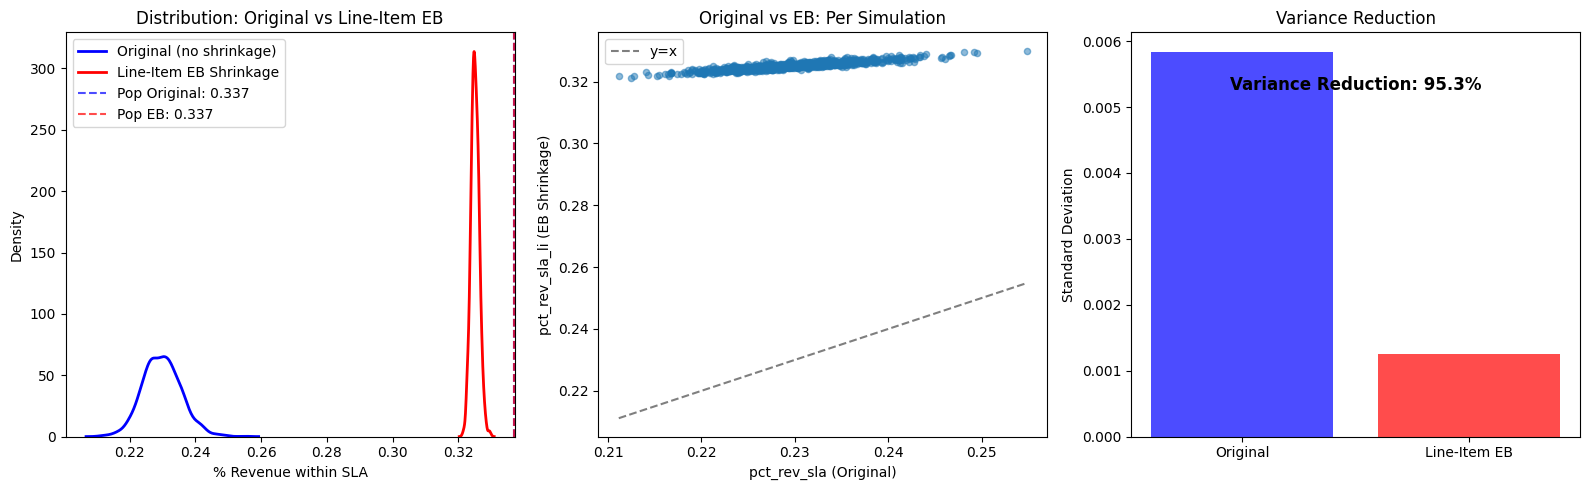


=== Summary Statistics ===
Metric                     Mean        Std        Min        Max
------------------------------------------------------------
pct_rev_sla              0.2298     0.0058     0.2111     0.2549
pct_rev_sla_li           0.3251     0.0013     0.3213     0.3300

Variance Reduction: 95.35%


In [35]:
# Compare pct_rev_sla vs pct_rev_sla_li
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Distribution comparison (for sampled data)
ax1 = axes[0]
sns.kdeplot(data=df_sampled_1201_agg['pct_rev_sla'], ax=ax1, 
            label='Original (no shrinkage)', color='blue', linewidth=2)
sns.kdeplot(data=df_sampled_1201_agg['pct_rev_sla_li'], ax=ax1, 
            label='Line-Item EB Shrinkage', color='red', linewidth=2)

# Add population value as vertical line
pop_val = df_all_1201_agg['pct_rev_sla'].iloc[0]
pop_val_li = df_all_1201_agg['pct_rev_sla_li'].iloc[0]
ax1.axvline(pop_val, color='blue', linestyle='--', alpha=0.7, label=f'Pop Original: {pop_val:.3f}')
ax1.axvline(pop_val_li, color='red', linestyle='--', alpha=0.7, label=f'Pop EB: {pop_val_li:.3f}')

ax1.set_xlabel('% Revenue within SLA')
ax1.set_ylabel('Density')
ax1.set_title('Distribution: Original vs Line-Item EB')
ax1.legend()

# 2. Scatter: Original vs EB
ax2 = axes[1]
ax2.scatter(df_sampled_1201_agg['pct_rev_sla'], df_sampled_1201_agg['pct_rev_sla_li'], 
            alpha=0.5, s=20)
ax2.plot([df_sampled_1201_agg['pct_rev_sla'].min(), df_sampled_1201_agg['pct_rev_sla'].max()],
         [df_sampled_1201_agg['pct_rev_sla'].min(), df_sampled_1201_agg['pct_rev_sla'].max()],
         'k--', alpha=0.5, label='y=x')
ax2.set_xlabel('pct_rev_sla (Original)')
ax2.set_ylabel('pct_rev_sla_li (EB Shrinkage)')
ax2.set_title('Original vs EB: Per Simulation')
ax2.legend()

# 3. Variance reduction
ax3 = axes[2]
metrics = ['pct_rev_sla', 'pct_rev_sla_li']
variances = [df_sampled_1201_agg[m].var() for m in metrics]
stds = [df_sampled_1201_agg[m].std() for m in metrics]

x = np.arange(len(metrics))
bars = ax3.bar(x, stds, color=['blue', 'red'], alpha=0.7)
ax3.set_xticks(x)
ax3.set_xticklabels(['Original', 'Line-Item EB'])
ax3.set_ylabel('Standard Deviation')
ax3.set_title('Variance Reduction')

# Add variance reduction percentage
var_reduction = (1 - variances[1] / variances[0]) * 100
ax3.text(0.5, max(stds) * 0.9, f'Variance Reduction: {var_reduction:.1f}%', 
         ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== Summary Statistics ===")
print(f"{'Metric':<20} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
print("-" * 60)
for col in ['pct_rev_sla', 'pct_rev_sla_li']:
    print(f"{col:<20} {df_sampled_1201_agg[col].mean():>10.4f} {df_sampled_1201_agg[col].std():>10.4f} "
          f"{df_sampled_1201_agg[col].min():>10.4f} {df_sampled_1201_agg[col].max():>10.4f}")

print(f"\nVariance Reduction: {var_reduction:.2f}%")

In [19]:
def fetch_aa_df(suffix):
  query= f"""
          with temp as
          (select iteration_id as sim_id,
           line_item_id,
           conv_{suffix} as conversions,
           pred_conv_{suffix} as conversions_pred,
           rev_{suffix} as revenue,
           case
           when conv_{suffix} > 0
                and (pred_conv_{suffix} / conv_{suffix}) > 0.8
                and (pred_conv_{suffix} / conv_{suffix}) < 1.2
                then 1 else 0
           end as sla_flag
           from `sc-analytics-privacy.ad_hoc_analysis.aa_full_sample_results_20260101_20260107`
           )
           select *,
           sla_flag * revenue as rev_sla
           from temp
           """
  df = client.query(query).to_dataframe()
  return df

df_a1 = fetch_aa_df('a1')
df_a2 = fetch_aa_df('a2')

E0000 00:00:1770935601.466483 2851288 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1770935646.561080 2851288 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


# AA Test Prior

In [37]:
df_all_one_week = calculate_sla_metrics(table_name = table_names['one_week_pop'])

E0000 00:00:1770939387.802830 2851288 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [38]:
# Estimate line-item priors from one-week data
print("\n=== Line-Item Priors for AA Test (from one-week data) ===")
aa_line_item_priors = estimate_line_item_priors(df_all_one_week)

# Check overlap
aa_line_items = set(df_a1['line_item_id'].unique())
prior_line_items = set(aa_line_item_priors.keys())
overlap = aa_line_items.intersection(prior_line_items)
print(f"AA test line items with prior: {len(overlap)}/{len(aa_line_items)}")


=== Line-Item Priors for AA Test (from one-week data) ===
Estimated priors for 254004 line items (pure own data)
AA test line items with prior: 230816/230816


In [39]:
def run_aa_test_on_priors(df_a1, df_a2, line_item_priors, samples=300):
    """
    A/A test using LINE-ITEM SPECIFIC priors (no global).
    Each line item uses its own prior from line_item_priors dict.
    """
    sim_ids = df_a1['sim_id'].unique()
    fps = 0
    
    for sid in sim_ids:
        iter_a1 = df_a1[df_a1['sim_id'] == sid].copy()
        iter_a2 = df_a2[df_a2['sim_id'] == sid].copy()
        
        # Look up LINE-ITEM SPECIFIC priors
        alpha_prior_a1 = np.array([
            line_item_priors[li][0] if li in line_item_priors else np.nan 
            for li in iter_a1['line_item_id']
        ])
        beta_prior_a1 = np.array([
            line_item_priors[li][1] if li in line_item_priors else np.nan 
            for li in iter_a1['line_item_id']
        ])
        
        alpha_prior_a2 = np.array([
            line_item_priors[li][0] if li in line_item_priors else np.nan 
            for li in iter_a2['line_item_id']
        ])
        beta_prior_a2 = np.array([
            line_item_priors[li][1] if li in line_item_priors else np.nan 
            for li in iter_a2['line_item_id']
        ])
        
        # Get data
        conv1 = iter_a1['conversions'].to_numpy(dtype=float)
        flag1 = iter_a1['sla_flag'].to_numpy(dtype=float)
        rev1 = iter_a1['revenue'].to_numpy(dtype=float)[:, None]
        
        conv2 = iter_a2['conversions'].to_numpy(dtype=float)
        flag2 = iter_a2['sla_flag'].to_numpy(dtype=float)
        rev2 = iter_a2['revenue'].to_numpy(dtype=float)[:, None]
        
        # Evidence: k successes out of n trials (weighted by sqrt(conv))
        n1 = np.sqrt(conv1)
        k1 = flag1 * n1
        
        n2 = np.sqrt(conv2)
        k2 = flag2 * n2
        
        # Posterior = Prior + Evidence
        alpha_post_a1 = alpha_prior_a1 + k1
        beta_post_a1 = beta_prior_a1 + (n1 - k1)
        
        alpha_post_a2 = alpha_prior_a2 + k2
        beta_post_a2 = beta_prior_a2 + (n2 - k2)
        
        # Monte Carlo sampling (line-item specific posteriors)
        s1 = np.random.beta(alpha_post_a1[:, None], beta_post_a1[:, None],
                            size=(len(iter_a1), samples))
        s2 = np.random.beta(alpha_post_a2[:, None], beta_post_a2[:, None],
                            size=(len(iter_a2), samples))
        
        # Revenue-weighted aggregation
        dist_a1 = (s1 * rev1).sum(axis=0) / rev1.sum()
        dist_a2 = (s2 * rev2).sum(axis=0) / rev2.sum()
        
        # Statistical check (2-tailed 95%)
        prob_a2_wins = (dist_a2 > dist_a1).mean()
        
        if prob_a2_wins > 0.975 or prob_a2_wins < 0.025:
            fps += 1
    
    fp_rate = fps / len(sim_ids)
    print(f"False positives: {fps}/{len(sim_ids)} = {fp_rate:.3f}")
    print(f"Verdict: {'SAFE' if fp_rate <= 0.05 else 'NOISY'}")
    
    return pd.DataFrame([{
        'method': 'line_item_priors',
        'false_positives': fps,
        'fp_rate': fp_rate,
        'verdict': 'SAFE' if fp_rate <= 0.05 else 'NOISY'
    }])

# Run AA test with line-item priors
print("\n=== AA Test with Line-Item Priors ===")
aa_results = run_aa_test_on_priors(df_a1, df_a2, aa_line_item_priors, samples=500)
print(aa_results)



=== AA Test with Line-Item Priors ===
False positives: 23/100 = 0.230
Verdict: NOISY
             method  false_positives  fp_rate verdict
0  line_item_priors               23     0.23   NOISY
